## 初步的分析
希望了解这个数据集的概况

有多少数据，多少特征，分别是什么特征，有什么特点之类的…


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
print("Shape of original train dataset: ", train.shape)
print("Shape of original test   dateset: ", test.shape)

Shape of original train dataset:  (4209, 378)
Shape of original test   dateset:  (4209, 377)


In [4]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
y_train = train['y']
id_test = test['ID']
train.drop(['ID', 'y'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)
all_data = pd.concat([train, test])

In [15]:
# 对分类属性编码
all_data = pd.get_dummies(all_data, prefix='X1', prefix_sep='_')

In [16]:
# 构造训练集和测试集
X_train = all_data.iloc[:len(y_train), :]
X_test = all_data.iloc[len(y_train):, ]

### 关于特征
数据集在ID和y以外，包括了376个特征

其中有356个包含了[0, 1]，12个特征全是0，8个是object特征

所以似乎最后可以feature engineer的地方大部分集中在8个object特征上了

### 关于categorical特征

In [25]:
# 取出一个只包含分类属性的子集用于分析
train_cat = train.iloc[:, 1:10]

In [26]:
train_cat.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8
0,130.81,k,v,at,a,d,u,j,o
1,88.53,k,t,av,e,d,y,l,o
2,76.26,az,w,n,c,d,x,j,x
3,80.62,az,t,n,f,d,x,l,e
4,78.02,az,v,n,f,d,h,d,n


In [32]:
# x0特征的值列表，其余特征的值也是类似的
val_x0 = train_cat['X0'].unique()
val_x0.sort()
val_x0

array(['a', 'aa', 'ab', 'ac', 'ad', 'af', 'ai', 'aj', 'ak', 'al', 'am',
       'ao', 'ap', 'aq', 'as', 'at', 'au', 'aw', 'ax', 'ay', 'az', 'b',
       'ba', 'bc', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype=object)

### 关于分类属性
分类属性使用一种字母表编码，处理方法：
1. 可以直接按照字母表顺序映射，双字母按照后一位字母顺序+26
2. 考虑双字母编码和第一位是否有关

In [122]:
X_test.head()

,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [124]:
# 训练lasso模型
lasso_model = LassoCV(cv=10, max_iter=1500).fit(X_train, y_train)

D:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


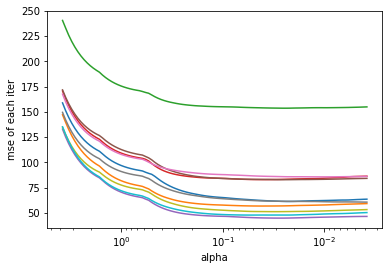

In [56]:
# 可视化alpha和mse
plt.semilogx(lasso_model.alphas_ , lasso_model.mse_path_)
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('mse of each iter')
plt.legend()

In [57]:
# 使用r2评估模型
def r2_score(model):
    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=10).mean()
    return r2


In [125]:
r2_ridge = [r2_score(Ridge(alpha=alpha).fit(X_train, y_train)).mean() for alpha in np.arange(1, 100)]

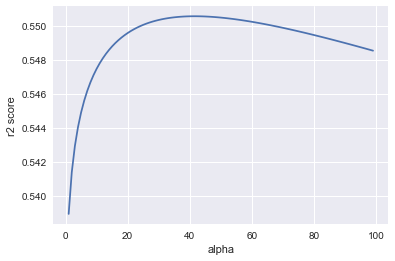

In [127]:
plt.plot(np.arange(1, 100), r2_ridge)
plt.xlabel('alpha')
plt.ylabel('r2 score')

In [128]:
print("max r2 in ridge model:", max(r2_ridge))

max r2 in ridge model: 0.55056022925


In [130]:
model_lasso.alpha_

0.025037085286072597

In [138]:
lasso = Lasso(alpha=model_lasso.alpha_).fit(X_train, y_train)

In [140]:
r2_score(lasso).mean()

0.55928821028682851

In [131]:
model_lasso.score(X_train, y_train)

0.56091536695088795

In [132]:
max(r2_ridge)

0.55056022924978154

In [141]:
pred = lasso.predict(X_test)

In [144]:
predcv = model_lasso.predict(X_test)

In [146]:
pred[:10]

array([  79.07564832,   94.93017438,   79.37326817,   78.45952755,
        110.7915895 ,   91.15797201,  110.81368952,   93.52939371,
        115.84937828,   95.49387502])

In [147]:
predcv[:10]

array([  79.07564832,   94.93017438,   79.37326817,   78.45952755,
        110.7915895 ,   91.15797201,  110.81368952,   93.52939371,
        115.84937828,   95.49387502])

In [143]:
pd.DataFrame({'ID': test['ID'], 'y': pred}).to_csv('submission.csv', index=False)

### 尝试一下ElasticNet
![](http://scikit-learn.org/stable/_images/math/51443eb62398fc5253e0a0d06a5695686e972d08.png)

In [17]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [18]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=10, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

In [19]:
cv_model.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=2000,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [20]:
print("Optimal alpha is: ", cv_model.alpha_)
print("Optimal l1_ratio is: ", cv_model.l1_ratio_)
print("Num of iterations is: ", cv_model.n_iter_)

Optimal alpha is:  0.00206946270684
Optimal l1_ratio is:  1.0
Num of iterations is:  1383


In [11]:
cv_model.mse_path_[1].mean(axis=1).shape

(100,)

[]

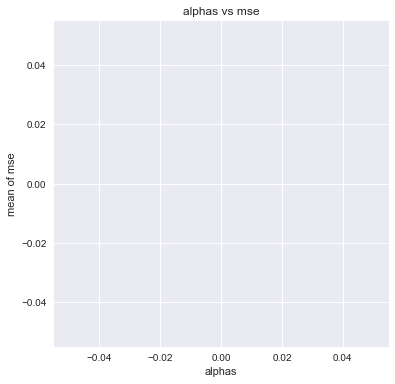

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set(title='alphas vs mse', xlabel='alphas', ylabel='mean of mse')
ax.plot(x=cv_model.alphas_[1], y=cv_model.mse_path_[1].mean(axis=1))

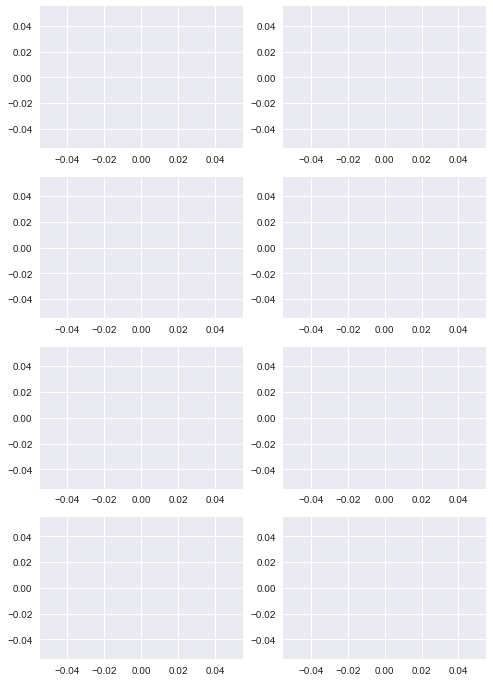

In [13]:
fig, ax_list = plt.subplots(nrows=4, ncols=2, figsize=(8, 12))
# ax.set(title='alphas vs mse', xlabel='alphas', ylabel='mean of mse')
for i in range(cv_model.mse_path_.shape[0]):
    row = i // 2
    col = i % 2
    ax_list[row][col].plot(x=cv_model.alphas_[i], y=cv_model.mse_path_[i].mean(axis=1))


In [21]:
# 用最优化参数训练一个模型
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(X_train, y_train)

ElasticNet(alpha=0.0020694627068383736, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=1383, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [22]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_train)
print(r2_score(y_train, y_pred))

0.596120922761


In [100]:
# 保存ElasticNet的预测结果
# y_pred = model.predict(X_test)
# pd.DataFrame({'ID': id_test, 'y':y_pred}).to_csv('submission0629.csv', index=False)

### 结论
ElasticNet的结果比Lasso的结果稍好，但差距不大

应该尝试更多的特征处理的方法

### 特征重要性
对比模型中的beta值，观察特征重要性

In [23]:
np.count_nonzero(model.coef_ > 0)

73

In [24]:
feat_imp = pd.Series(index=X_train.columns, data=abs(model.coef_))
n_feature_selected = np.count_nonzero(model.coef_ > 0)
print("{:d} features selected, reduced {:.4f}%".format(
    n_feature_selected, (1 - n_feature_selected / len(model.coef_)) * 100))

73 features selected, reduced 87.3921%


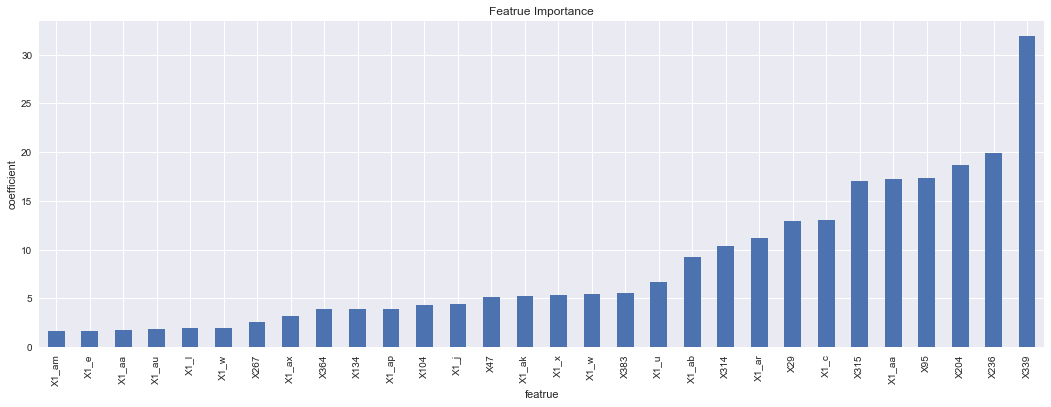

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
feat_imp.sort_values().tail(30).plot(kind='bar')
title, xlabel, ylabel = ax.set(title='Featrue Importance', xlabel='featrue', ylabel='coefficient')

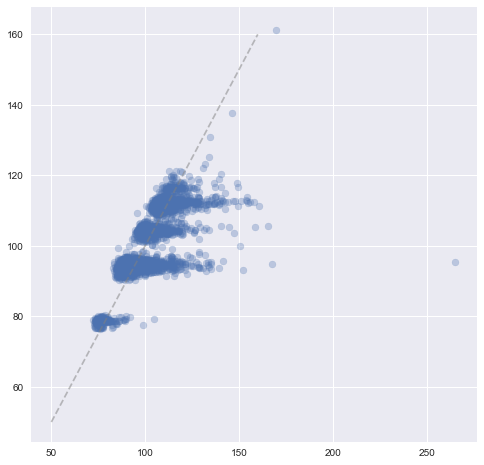

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([50, 160], [50,160], '--', alpha=0.5, color='gray')
ax.scatter(y_train, y_pred, alpha=0.3)

In [43]:
train.index.values

array([   0,    1,    2, ..., 4206, 4207, 4208], dtype=int64)

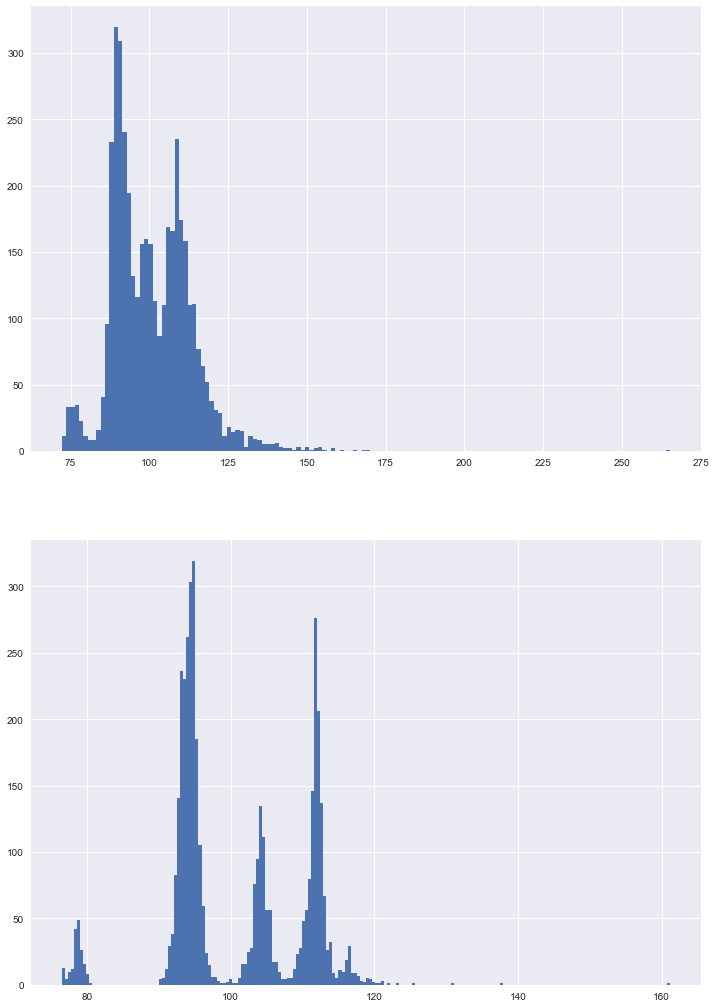

In [52]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(12,18))
a0 = ax0.hist(y_train, bins=140)
a1 = ax1.hist(y_pred, bins=200)